In [22]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from art.estimators.classification import KerasClassifier
import keras
from tensorflow.keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

In [2]:
path_root = "D:\\UVG\\9noSemestre\\SecurityDataScience\\Proyecto3---Security-DS\\malimg_dataset\\malimg_paper_dataset_imgs\\"

In [3]:
from keras.preprocessing.image import ImageDataGenerator

batches = ImageDataGenerator().flow_from_directory(directory = path_root, target_size = (64, 64), batch_size = 10000)

Found 9339 images belonging to 25 classes.


In [4]:
# Usamos next() para recorrer todos los elementos y generar un batch de imagenes y label del data set
imgs, labels = next(batches)

In [5]:
# nuestras imagenes estan en RGB con formato 64x64 [width x length x depth].
imgs.shape

(9339, 64, 64, 3)

# Entrenamiento y prueba
Se divide la data en 70% train y 30% test 

In [6]:
X_train, X_test0, y_train, y_test0 = train_test_split(imgs / 255., labels, test_size = 0.45)

In [7]:
X_test, X_steal, y_test, y_steal = train_test_split(X_test0, y_test0, test_size=0.33, random_state = 31)

In [8]:
X_train.shape

(5136, 64, 64, 3)

# Modelo de Red Neural Convolutional

In [9]:
num_classes = 25

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [10]:
Malware_model = malware_model()

In [11]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 15)        0         
                                                                 
 flatten (Flatten)           (None, 2940)              0

In [12]:
y_train.shape

(5136, 25)

In [13]:
y_train_new = np.argmax(y_train, axis=1)
y_train_new

array([16,  3,  2, ..., 22, 24,  8], dtype=int64)

In [14]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
161/161 [==============================] - 9s 56ms/step - loss: 1.8234 - accuracy: 0.4603 - val_loss: 0.9919 - val_accuracy: 0.6431
Epoch 2/10
161/161 [==============================] - 8s 52ms/step - loss: 0.9679 - accuracy: 0.6690 - val_loss: 0.5809 - val_accuracy: 0.8153
Epoch 3/10
161/161 [==============================] - 8s 52ms/step - loss: 0.6552 - accuracy: 0.7833 - val_loss: 0.3607 - val_accuracy: 0.9016
Epoch 4/10
161/161 [==============================] - 8s 51ms/step - loss: 0.4468 - accuracy: 0.8571 - val_loss: 0.2317 - val_accuracy: 0.9240
Epoch 5/10
161/161 [==============================] - 8s 51ms/step - loss: 0.3508 - accuracy: 0.8910 - val_loss: 0.1929 - val_accuracy: 0.9311
Epoch 6/10
161/161 [==============================] - 9s 54ms/step - loss: 0.2756 - accuracy: 0.9132 - val_loss: 0.1689 - val_accuracy: 0.9478
Epoch 7/10
161/161 [==============================] - 9s 54ms/step - loss: 0.2437 - accuracy: 0.9206 - val_loss: 0.1550 - val_accuracy: 0.9528

In [15]:
scores = Malware_model.evaluate(X_test, y_test)

88/88 [==============================] - 1s 10ms/step - loss: 0.1368 - accuracy: 0.9556


In [16]:
print('Accuracy final CNN: ', scores[1])
# Fue bastante alto el acc obtenido

Accuracy final CNN:  0.9556108117103577


In [17]:
# se guarda el modelo 
Malware_model.save('malware-listo-model.h5')

In [18]:
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

In [19]:
# Recrea exactamente el mismo modelo solo desde el archivo
malware_model = keras.models.load_model('malware-listo-model.h5')

In [20]:
classifier_original = KerasClassifier(malware_model, clip_values=(0, 1), use_logits=False)

In [25]:
num_epochs = 10
len_steal = 5000
# Stealing from the unprotected classifier.
attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

In [30]:
def malware_steal_model():
    Malware_model = Sequential(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))
   
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [32]:
results = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(X_test0))
    x_steal = X_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = X_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = malware_steal_model()
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

Train on 250 samples
Epoch 1/10
250/250 [==============================] - 3s 12ms/sample - loss: 2.9509 - accuracy: 0.2280
Epoch 2/10
250/250 [==============================] - 3s 11ms/sample - loss: 2.6873 - accuracy: 0.2880
Epoch 3/10
250/250 [==============================] - 3s 11ms/sample - loss: 2.5835 - accuracy: 0.2240
Epoch 4/10
250/250 [==============================] - 3s 11ms/sample - loss: 2.4912 - accuracy: 0.2880
Epoch 5/10
250/250 [==============================] - 3s 11ms/sample - loss: 2.3880 - accuracy: 0.3280
Epoch 6/10
250/250 [==============================] - 3s 11ms/sample - loss: 2.3663 - accuracy: 0.3280
Epoch 7/10
250/250 [==============================] - 3s 10ms/sample - loss: 2.2356 - accuracy: 0.3600
Epoch 8/10
250/250 [==============================] - 3s 11ms/sample - loss: 2.1291 - accuracy: 0.3440
Epoch 9/10
250/250 [==============================] - 3s 10ms/sample - loss: 2.0010 - accuracy: 0.3880
Epoch 10/10
250/250 [==============================]

2000/2000 [==============================] - 29s 14ms/sample - loss: 1.5863 - accuracy: 0.5020
Epoch 4/10
2000/2000 [==============================] - 29s 14ms/sample - loss: 1.2190 - accuracy: 0.5975
Epoch 5/10
2000/2000 [==============================] - 29s 15ms/sample - loss: 1.0118 - accuracy: 0.6570
Epoch 6/10
2000/2000 [==============================] - 29s 15ms/sample - loss: 0.8627 - accuracy: 0.7045
Epoch 7/10
2000/2000 [==============================] - 29s 15ms/sample - loss: 0.7206 - accuracy: 0.7555
Epoch 8/10
2000/2000 [==============================] - 30s 15ms/sample - loss: 0.6637 - accuracy: 0.7785
Epoch 9/10
2000/2000 [==============================] - 32s 16ms/sample - loss: 0.5429 - accuracy: 0.8185
Epoch 10/10
2000/2000 [==============================] - 30s 15ms/sample - loss: 0.4682 - accuracy: 0.8525
Argmax CopycatCNN : 0.8969587
Probabilistic KnockoffNets : 0.901044
Argmax KnockoffNets : 0.9001362
Train on 4000 samples
Epoch 1/10
4000/4000 [==================

KeyboardInterrupt: 

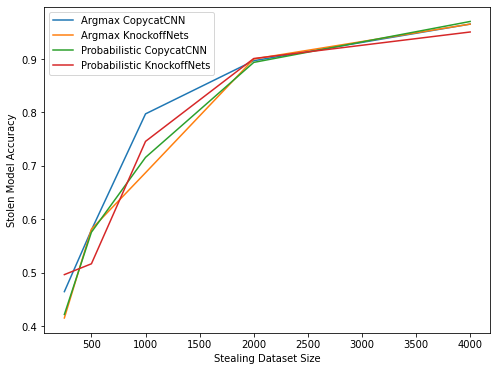

In [33]:
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()